In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import MDS

In [2]:
# Tamanho do array
n = 0
# Matriz de distância
dist_df = []
# Matriz de custo
flow_df  = []

In [3]:
def gerar_array_replicavel(seed: int, tamanho: int) -> list[int]:
    random.seed(seed)
    vetor = list(range(tamanho))  
    random.shuffle(vetor)
    return vetor

In [4]:
def generate_neighborhood_1(sol: list[int]) -> list[list[int]]:
  neighborhood = []
  for i in range(len(sol)-1):
    neighbor = sol[:]
    neighbor[i], neighbor[i+1] = neighbor[i+1], neighbor[i]
    neighborhood.append(neighbor)
  return neighborhood


def generate_neighborhood_2(sol: list[int]) -> list[list[int]]:
  neighborhood = []
  for i in range(len(sol)-2):
    neighbor = sol[:]
    neighbor[i], neighbor[i+2] = neighbor[i+2], neighbor[i]
    neighborhood.append(neighbor)
  return neighborhood

In [5]:
def solution_score(sol: list[int], flow: list[list[float]], dist: list[list[float]]) -> float:
    n = len(sol)
    if len(flow) != n or len(dist) != n:
        raise ValueError("Tamanhos incompatíveis entre solução, fluxo e distância")

    score = 0.0
    for i in range(n):
        for j in range(n):
            a = sol[i]
            b = sol[j]
            score += flow[a][b] * dist[i][j]
    return score


In [ ]:
def ler_qap_com_n(caminho: str):
    with open(caminho, "r") as f:
        dados = list(map(int, f.read().split()))
        
    n = dados[0]
    valores = dados[1:]  

    total_esperado = 2 * n * n
    if len(valores) != total_esperado:
        raise ValueError(f"Esperado {total_esperado} valores, mas encontrado {len(valores)}.")

    flow_flat = valores[:n * n]
    dist_flat = valores[n * n:]

    flow_df = pd.DataFrame([flow_flat[i * n:(i + 1) * n] for i in range(n)])
    dist_df = pd.DataFrame([dist_flat[i * n:(i + 1) * n] for i in range(n)])

    return n, flow_df, dist_df

n, flow_df, dist_df = ler_qap_com_n("Tho150.txt")

flow = flow_df.values.tolist()
dist = dist_df.values.tolist()

In [7]:
solucao_inicial = gerar_array_replicavel(seed=42, tamanho=n)
solucao_inicial

[63,
 133,
 109,
 134,
 75,
 61,
 130,
 39,
 40,
 38,
 65,
 85,
 0,
 141,
 95,
 32,
 131,
 18,
 83,
 30,
 119,
 132,
 72,
 123,
 128,
 136,
 3,
 53,
 127,
 92,
 60,
 67,
 42,
 146,
 137,
 110,
 118,
 86,
 116,
 66,
 81,
 101,
 91,
 16,
 104,
 88,
 49,
 145,
 98,
 64,
 122,
 96,
 76,
 36,
 115,
 4,
 17,
 25,
 69,
 51,
 2,
 52,
 14,
 138,
 41,
 149,
 74,
 82,
 135,
 78,
 31,
 102,
 21,
 9,
 34,
 143,
 111,
 47,
 124,
 94,
 106,
 120,
 100,
 112,
 87,
 99,
 117,
 29,
 84,
 105,
 142,
 90,
 24,
 73,
 46,
 79,
 80,
 37,
 147,
 10,
 113,
 15,
 68,
 58,
 93,
 5,
 125,
 33,
 77,
 44,
 140,
 45,
 12,
 48,
 11,
 13,
 121,
 126,
 27,
 19,
 144,
 43,
 54,
 89,
 20,
 103,
 97,
 1,
 71,
 114,
 56,
 107,
 50,
 148,
 129,
 59,
 55,
 23,
 7,
 8,
 108,
 22,
 139,
 26,
 35,
 57,
 62,
 70,
 6,
 28]

In [8]:
solution_score(solucao_inicial, flow_df, dist_df)

np.float64(9705284.0)

In [9]:
def plotar_solucao(solucao, flow_df, dist_df, titulo="Solução QAP Dinâmica"):
    n = len(solucao)
    dist_array = np.array(dist_df)

    dist_reordenada = dist_array[np.ix_(solucao, solucao)]

    dist_reordenada = (dist_reordenada + dist_reordenada.T) / 2

    np.fill_diagonal(dist_reordenada, 0)

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    coords = mds.fit_transform(dist_reordenada)

    plt.figure(figsize=(8, 6))

    for i in range(n):
        for j in range(i + 1, n):
            largura = 0.5 + 4 * (flow_df.iloc[solucao[i], solucao[j]] / flow_df.values.max())
            plt.plot(
                [coords[i, 0], coords[j, 0]],
                [coords[i, 1], coords[j, 1]],
                color="blue",
                alpha=0.5,
                linewidth=largura
            )

    plt.scatter(coords[:, 0], coords[:, 1], color="#add8e6", s=300, edgecolors="black", zorder=3)

    for i in range(n):
        plt.annotate(str(solucao[i]), (coords[i, 0], coords[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.title(titulo)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


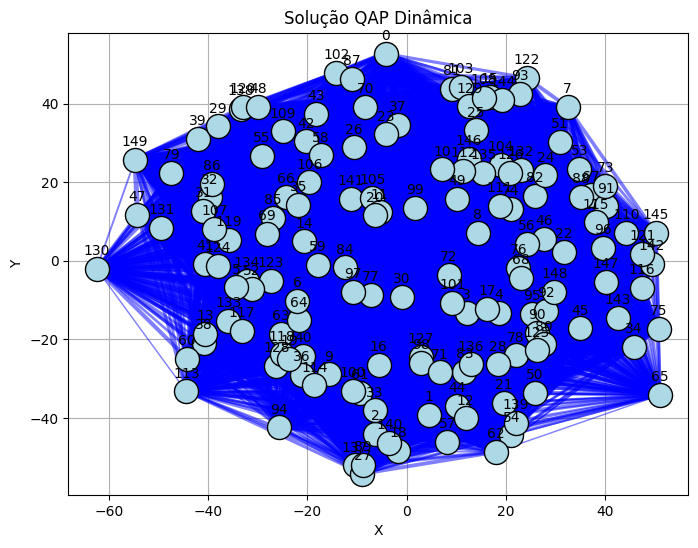

In [10]:
plotar_solucao(solucao_inicial, flow_df, dist_df)

In [11]:
def get_best_solution(neighborhood, flow, dist):
    best_sol = None
    best_score = float('inf')
    for sol in neighborhood:
        score = solution_score(sol, flow, dist)
        if score < best_score:
            best_score = score
            best_sol = sol
    return best_sol


In [12]:
def print_solution(sol: list[int], flow, dist) -> None:
    print("Solution:", sol)
    print("Score:", f"{solution_score(sol, flow, dist):.2f}")
    print()


neighborhood_generators = [generate_neighborhood_1, generate_neighborhood_2]
r = len(neighborhood_generators)

curr_sol = solucao_inicial
k = 0
while k < r:
    neighborhood = neighborhood_generators[k](curr_sol)
    best_neighbor = get_best_solution(neighborhood, flow_df.values.tolist(), dist_df.values.tolist())
    if solution_score(best_neighbor, flow_df.values.tolist(), dist_df.values.tolist()) < \
       solution_score(curr_sol, flow_df.values.tolist(), dist_df.values.tolist()):
        print_solution(curr_sol, flow_df.values.tolist(), dist_df.values.tolist())
        curr_sol = best_neighbor
        k = 0
    else:
        k += 1

print_solution(curr_sol, flow_df.values.tolist(), dist_df.values.tolist())


Solution: [63, 133, 109, 134, 75, 61, 130, 39, 40, 38, 65, 85, 0, 141, 95, 32, 131, 18, 83, 30, 119, 132, 72, 123, 128, 136, 3, 53, 127, 92, 60, 67, 42, 146, 137, 110, 118, 86, 116, 66, 81, 101, 91, 16, 104, 88, 49, 145, 98, 64, 122, 96, 76, 36, 115, 4, 17, 25, 69, 51, 2, 52, 14, 138, 41, 149, 74, 82, 135, 78, 31, 102, 21, 9, 34, 143, 111, 47, 124, 94, 106, 120, 100, 112, 87, 99, 117, 29, 84, 105, 142, 90, 24, 73, 46, 79, 80, 37, 147, 10, 113, 15, 68, 58, 93, 5, 125, 33, 77, 44, 140, 45, 12, 48, 11, 13, 121, 126, 27, 19, 144, 43, 54, 89, 20, 103, 97, 1, 71, 114, 56, 107, 50, 148, 129, 59, 55, 23, 7, 8, 108, 22, 139, 26, 35, 57, 62, 70, 6, 28]
Score: 9705284.00

Solution: [63, 133, 109, 134, 75, 61, 130, 39, 40, 38, 65, 85, 0, 141, 95, 32, 131, 18, 83, 30, 119, 132, 72, 123, 128, 136, 3, 53, 127, 92, 60, 67, 42, 146, 137, 110, 118, 86, 116, 66, 81, 101, 91, 104, 16, 88, 49, 145, 98, 64, 122, 96, 76, 36, 115, 4, 17, 25, 69, 51, 2, 52, 14, 138, 41, 149, 74, 82, 135, 78, 31, 102, 21, 9, 34

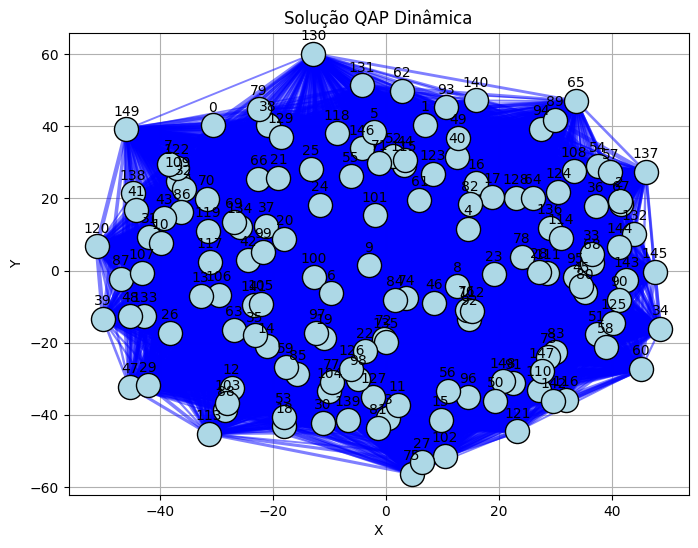

In [13]:
plotar_solucao(curr_sol, flow_df, dist_df)